# Load

In [32]:
import pandas as pd
import numpy as np
import polars as pl
import gc
import time

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score
from numpy.linalg import LinAlgError
from collections import defaultdict
from itertools import combinations
from catboost import Pool
from scipy import stats

pd.set_option('display.max_columns', None)
pl.Config.set_tbl_cols(None)

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

%matplotlib inline

np.random.seed(42)

In [33]:
train = pl.read_parquet('train.parquet')

# Functions

### Training:

In [34]:
def train_logit_model(X, y):
    X = sm.add_constant(X, has_constant='skip')
    
    model = sm.Logit(y, X).fit()
    return model

In [35]:
def train_xgboost_model(df, mandatory):
    X_train, X_test, y_train, y_test = preprocess4xgboost(df)
    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eta': 0.05,
        'alpha':  0.2545607592482198,
        'subsample': 0.8388163485383147, 
        'colsample_bytree': 0.2732499701466825, 
        "max_depth": 16,
        'min_child_weight': 5,
        'gamma': 0.0017688666476104672,
        "random_state": 42,
        "eval_metric": "auc",
        'max_bin': 262143,
        "nthreads": -1,
        "use_label_encoder": False,
        'n_estimators': 100,
    }
    eval = [(X_test, y_test)]
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=eval, verbose=True)
    return model

In [89]:
def train_lgmb_model(X_train, X_test, y_train, y_test):
    lgbm_params = {
        'n_estimators': 2000,
        'max_depth': 6,
        "early_stopping_round": 50,
        "max_bin": 262143,
        'num_leaves': 223,
        'learning_rate': 0.028095688623590447,
        'min_child_samples': 54,
        'subsample': 0.5395472919165504,
        'colsample_bytree': 0.547518064129546,
        'lambda_l1': 3.4444245446562,
        'lambda_l2': 2.87490408088595e-05
    }
    model = LGBMClassifier(**lgbm_params)

    model.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                eval_metric="auc")

    # Evaluate the model
    score = model.best_score_['valid_0']['auc']
    print('Fold ROC-AUC score: ', score)
    return model

### Preprocessing:

In [36]:
def preprocess4xgboost(df):
    df = df[:100000].to_pandas()
    X = df.drop(columns=['id', 'Response'], axis=1)
    y = df['Response']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    X_train, X_test = X_train[mandatory], X_test[mandatory]
    
    #dtrain = xgb.DMatrix(X_train, label=y_train)
    #dtest = xgb.DMatrix(X_test, label=y_test)
    return X_train, X_test, y_train, y_test

### Postprocessing:

In [37]:
def postprocess_data(y_pred, weights):
    y_pred = (y_pred*weights)/100
    return y_pred

### Submission:

In [38]:
def get_weights(df):
    df = df.with_columns([
        pl.when(pl.col('Vehicle_Damage') == 1)
          .then(0.2405)
          .otherwise(0.0041)
          .alias('vdamage_proba')
    ])
    
    df = df.with_columns([
        pl.when(pl.col('Previously_Insured') == 0)
          .then(0.2284)
          .otherwise(0.0006)
          .alias('pinsured_proba')
    ])
    
    df = df.with_columns([
        pl.when(pl.col('Vehicle_Age') == 0)
          .then(0.0414)
          .when(pl.col('Vehicle_Age') == 1)
          .then(0.1777)
          .otherwise(0.299)
          .alias('vage_proba')
    ])

    df = df.with_columns([
        pl.when(pl.col('Driving_License') == 0)
          .then(0.0551)
          .otherwise(0.1231)
          .alias('dlicence_proba')  
    ])

    
    df = df.with_columns([
        pl.lit(None).alias('age_proba'),
        pl.lit(None).alias('vintage_proba'),
        pl.lit(None).alias('psc_proba'),
    ])
    
    for i in range(20, 86):
        df = df.with_columns(
            pl.when(pl.col('Age') == i)
              .then(age[i-20])
              .otherwise(pl.col('age_proba'))
              .alias('age_proba')
        )

    for i in range(10, 300):
        df = df.with_columns(
            pl.when(pl.col('Vintage') == i)
              .then(vintage[i-20])
              .otherwise(pl.col('vintage_proba'))
              .alias('vintage_proba')
        )

    df = df.with_columns([
        pl.when(pl.col('Gender') == 0)
          .then(0.1032)
          .otherwise(0.1396)
          .alias('gender_proba')
    ])

    k = 0
    for i in psc_values:
        df = df.with_columns(
            pl.when(pl.col('Policy_Sales_Channel') == i)
              .then(channel[k])
              .when(pl.col('Policy_Sales_Channel') == 144)
              .then(channel[136])
              .when(pl.col('Policy_Sales_Channel') == 149)
              .then(channel[140])
              .otherwise(pl.col('psc_proba'))
              .alias('psc_proba')
        )
        k += 1

    df = df.with_columns([
        ((pl.col('psc_proba') * pl.col('gender_proba') * pl.col('vintage_proba') * pl.col('vdamage_proba') * pl.col('pinsured_proba') * pl.col('vage_proba') * pl.col('age_proba') * pl.col('dlicence_proba') * 10e16)**(1/8)).alias('weight')
    ])

    weights = df['weight'].to_pandas().values
    
    return df, weights

In [39]:
def new_features(df):
    df = df.with_columns([
        (pl.col('Previously_Insured') * (1 - pl.col('Vehicle_Damage'))).alias('pinsuredxvdamage1'),
        (pl.col('Vehicle_Damage') * (1 - pl.col('Previously_Insured'))).alias('pinsuredxvdamage2')
    ])
    return df

In [40]:
def prepare_data(path, mandatory):
    df = pl.read_parquet(path)
    df = pl_encoder(df)
    df, weights = get_weights(df)
    df = new_features(df)
    df[num_cols] = scaler.transform(df[num_cols])

    df = df.to_pandas()
    ids = df['id'].values
    df = df[mandatory].values
    return df, ids, weights

In [41]:
def predict(model, mandatory):
    df, ids, weights = prepare_data('test.parquet', mandatory)
    
    df = sm.add_constant(df, has_constant='skip')

    y_pred = model.predict(df)
    #y_pred = postprocess_data(y_pred, weights)
    return ids, y_pred

In [42]:
def make_submission_file(ids, predicted_response):
    predicted_prices_df = pd.DataFrame({
        'id': ids,
        'Response': predicted_response
    })
    predicted_prices_df.to_parquet('submission.parquet', index=False)

In [43]:
def submit(model):
    ids, predicted_response = predict(model, mandatory)
    make_submission_file(ids, predicted_response)

### Encoding:

In [44]:
def pl_encoder(df):
    df = df.with_columns([
        pl.when(pl.col('Gender') == 'Female').then(0)
          .when(pl.col('Gender') == 'Male').then(1)
          .otherwise(None)
          .alias('Gender').cast(pl.Int8),
        
        pl.col('Driving_License').cast(pl.Int8),
        pl.col('Previously_Insured').cast(pl.Int8),
        
        pl.when(pl.col('Vehicle_Age') == '< 1 Year').then(0)
          .when(pl.col('Vehicle_Age') == '1-2 Year').then(1)
          .when(pl.col('Vehicle_Age') == '> 2 Years').then(2)
          .otherwise(None)
          .alias('Vehicle_Age').cast(pl.Int8),
        
        pl.when(pl.col('Vehicle_Damage') == 'No').then(0)
          .when(pl.col('Vehicle_Damage') == 'Yes').then(1)
          .otherwise(None)
          .alias('Vehicle_Damage').cast(pl.Int8),
        
        pl.col('id').cast(pl.Int32),
        pl.col('Age').cast(pl.Int8),
        pl.col('Vintage').cast(pl.Int16),
        pl.col('Region_Code').cast(pl.Float32),
        pl.col('Annual_Premium').cast(pl.Float32),
        pl.col('Policy_Sales_Channel').cast(pl.Float32),
    ])
    return df

### Plotting:

In [45]:
def plot_date_components_histogram_seaborn(df, component, bins):
    fig = plt.figure(figsize=(15, 5))
    sns.histplot(data=df, x=component, bins=bins, multiple="stack", kde=False, hue='Response')
    plt.title(f'{component.capitalize()} Distribution')
    plt.xlabel(component.capitalize())
    plt.ylabel('Frequency')
    plt.show()

In [46]:
def plot_feature_importanc(df):
    model = train_xgboost_model(df, mandatory)
    feature_names = df.drop('id', 'Response').columns

    # Plot feature importances
    importances = model.feature_importances_
    display(importances)
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.bar(range(len(feature_names)), importances[indices], align='center')
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

In [47]:
def visualize_data(data, features):
    for feature in features:
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        sns.boxplot(data[feature])
        plt.title(f'Boxplot of {feature}')

        plt.subplot(1, 2, 2)
        sns.histplot(data[feature], kde=True)
        plt.title(f'Distribution of {feature}')

        plt.show()

In [48]:
def plot_residuals(residuals, y_pred):
    plt.scatter(y_pred, residuals)
    plt.title('Residuals vs. Predicted Values')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

In [49]:
def normality(residuals):
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Normal Q-Q plot')
    plt.show()

### CV:

In [50]:
def feature_combinations_with_mandatory(mandatory, remaining ,n):
    all_combinations = []
    combinations_r = combinations(remaining, n)
    for combo in combinations_r:
        all_combinations.append(mandatory + list(combo))
    return all_combinations

In [51]:
def score_logit_model(X_train, y_train, X_val, y_val, weights):
    model = train_logit_model(X_train, y_train)
    
    X_val = sm.add_constant(X_val)

    y_pred = model.predict(X_val)
    y_pred = postprocess_data(y_pred, weights)
    score = roc_auc_score(y_val, y_pred)
    return score

In [52]:
def k_folds(y, k):
    class_indices = defaultdict(list)
    for idx, label in enumerate(y):
        class_indices[label].append(idx)
        
    folds = [[] for _ in range(k)]
    for label, indices in class_indices.items():
        np.random.shuffle(indices)
        for i, index in enumerate(indices):
            folds[i % k].append(index)

    folds = [np.array(fold) for fold in folds]
    return folds

In [53]:
def cross_validate(X, y, weights, k):
    folds = k_folds(y, k)
    
    scores = []
    
    for i in range(k):
        val_indices = folds[i]
        train_indices = np.hstack([folds[j] for j in range(k) if j != i])
        
        X_train, X_val = X[train_indices], X[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]
        weight = weights[val_indices]
    
        scores.append(score_logit_model(X_train, y_train, X_val, y_val, weight))
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f'Cross-validation scores: {scores}')
    print(f'Mean cross-validation score: {mean_score}')
    print(f'Standard deviation of cross-validation scores: {std_score}')

# Feature Engineering

## Columns:

In [54]:
target = 'Response'
initial_cols = train.drop('Response').columns
initial_train_cols = train.drop('Response', 'id').columns
cat_cols = [col for col in initial_train_cols if train[col].dtype == pl.Utf8]
num_cols = [col for col in initial_train_cols if train[col].dtype in {pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64}]

## Encoding:

In [55]:
gender_map = {
    'Female': 0,
    'Male': 1
}

vehicle_age_map = {
    '< 1 Year': 0,
    '1-2 Year': 1,
    '> 2 Years': 2
}

vehicle_damage_map = {
    'No': 0,
    'Yes': 1
}

In [56]:
train = pl_encoder(train)

## Weights:

In [57]:
age = []
for i in range(20, 86):
    middle = train.filter(pl.col('Age') == i)
    if middle['Response'].value_counts().filter(pl.col('Response') == 1).shape[0] != 0:
        age.append(middle['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / middle.shape[0])
        
    else:
        age.append(0)

vintage = []
for i in range(10, 300):
    middle = train.filter(pl.col('Vintage') == i)
    if middle['Response'].value_counts().filter(pl.col('Response') == 1).shape[0] != 0:
        vintage.append(middle['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / middle.shape[0])
        
    else:
        vintage.append(0)

psc_values = train['Policy_Sales_Channel'].value_counts()['Policy_Sales_Channel'].to_pandas().sort_values().tolist()
channel = []
for i in psc_values:
    middle = train.filter(pl.col('Policy_Sales_Channel') == i)
    if middle['Response'].value_counts().filter(pl.col('Response') == 1).shape[0] != 0:
        channel.append(middle['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / middle.shape[0])
        
    else:
        channel.append(0)

In [58]:
train = train.with_columns([
    pl.when(pl.col('Vehicle_Damage') == 1)
      .then(0.2405)
      .otherwise(0.0041)
      .alias('vdamage_proba')
])

train = train.with_columns([
    pl.when(pl.col('Previously_Insured') == 0)
      .then(0.2284)
      .otherwise(0.0006)
      .alias('pinsured_proba')
])

train = train.with_columns([
    pl.when(pl.col('Vehicle_Age') == 0)
      .then(0.0414)
      .when(pl.col('Vehicle_Age') == 1)
      .then(0.1777)
      .otherwise(0.299)
      .alias('vage_proba')
])

train = train.with_columns([
    pl.when(pl.col('Driving_License') == 0)
      .then(0.0551)
      .otherwise(0.1231)
      .alias('dlicence_proba')  
])

train = train.with_columns([
    pl.lit(None).alias('age_proba'),
    pl.lit(None).alias('vintage_proba'),
    pl.lit(None).alias('psc_proba'),
])

for i in range(20, 86):
    train = train.with_columns(
        pl.when(pl.col('Age') == i)
          .then(age[i-20])
          .otherwise(pl.col('age_proba'))
          .alias('age_proba')
    )

for i in range(10, 300):
    train = train.with_columns(
        pl.when(pl.col('Vintage') == i)
          .then(vintage[i-20])
          .otherwise(pl.col('vintage_proba'))
          .alias('vintage_proba')
    )

train = train.with_columns([
    pl.when(pl.col('Gender') == 0)
      .then(0.1032)
      .otherwise(0.1396)
      .alias('gender_proba')
])

k = 0
for i in psc_values:
    train = train.with_columns(
        pl.when(pl.col('Policy_Sales_Channel') == i)
          .then(channel[k])

        
          .when(pl.col('Policy_Sales_Channel') == 144)
          .then(channel[136])
          .when(pl.col('Policy_Sales_Channel') == 149)
          .then(channel[140])
          
        
          .otherwise(pl.col('psc_proba'))
          .alias('psc_proba')
    )
    k += 1

In [59]:
train = train.with_columns([
    (3.19 * ((pl.col('psc_proba') * pl.col('gender_proba') * pl.col('vintage_proba') * pl.col('vdamage_proba') * pl.col('pinsured_proba') * pl.col('vage_proba') * pl.col('age_proba') * pl.col('dlicence_proba') * 10e16)**(1/8))).alias('weight')
])

In [60]:
train[['vdamage_proba', 'pinsured_proba', 'vage_proba', 'age_proba', 'dlicence_proba', 'vintage_proba', 'weight', 'Response']]

vdamage_proba,pinsured_proba,vage_proba,age_proba,dlicence_proba,vintage_proba,weight,Response
f64,f64,f64,f64,f64,f64,f64,i64
0.2405,0.2284,0.1777,0.031871,0.1231,0.102365,57.097478,0
0.2405,0.2284,0.299,0.220596,0.1231,0.099191,78.041165,1
0.0041,0.0006,0.0414,0.031249,0.1231,0.190378,11.013231,0
0.2405,0.2284,0.1777,0.225718,0.1231,0.09108,69.749962,0
0.0041,0.0006,0.1777,0.229487,0.1231,0.079272,15.19425,0
…,…,…,…,…,…,…,…
0.2405,0.2284,0.1777,0.217931,0.1231,0.248087,81.880863,0
0.2405,0.2284,0.0414,0.032568,0.1231,0.123129,36.65328,1
0.0041,0.0006,0.0414,0.104322,0.1231,0.123332,12.128032,0


In [61]:
weights = train['weight'].to_pandas().values

## New Feature:

In [62]:
train = train.with_columns([
    (pl.col('Previously_Insured') * (1 - pl.col('Vehicle_Damage'))).alias('pinsuredxvdamage1'),
    (pl.col('Vehicle_Damage') * (1 - pl.col('Previously_Insured'))).alias('pinsuredxvdamage2')
])

## EDA:

In [27]:
train

id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,vdamage_proba,pinsured_proba,vage_proba,age_proba,dlicence_proba,vintage_proba,gender_proba,weight
i32,i8,i8,i8,f32,i8,i8,i8,f32,f32,i16,i64,f64,f64,f64,f64,f64,f64,f64,f64
0,1,21,1,35.0,0,1,1,65101.0,124.0,187,0,24.05,22.84,17.77,3.187101,12.31,10.236454,13.96,5.4725e7
1,1,43,1,28.0,0,2,1,58911.0,26.0,288,1,24.05,22.84,29.9,22.059585,12.31,9.919121,13.96,6.1758e8
2,0,25,1,14.0,1,0,0,38043.0,152.0,254,0,0.41,0.06,4.14,3.124857,12.31,19.037847,10.32,769.699546
3,0,35,1,1.0,0,1,1,2630.0,156.0,76,0,24.05,22.84,17.77,22.571795,12.31,9.108028,10.32,2.5493e8
4,0,36,1,15.0,1,1,0,31951.0,152.0,294,0,0.41,0.06,17.77,22.948659,12.31,7.927203,10.32,10102.702437
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
11504793,1,48,1,6.0,0,1,1,27412.0,26.0,218,0,24.05,22.84,17.77,21.793098,12.31,24.808737,13.96,9.0691e8
11504794,0,26,1,36.0,0,0,1,29509.0,152.0,115,1,24.05,22.84,4.14,3.256837,12.31,12.312915,10.32,1.1585e7
11504795,0,29,1,32.0,1,0,0,2630.0,152.0,189,0,0.41,0.06,4.14,10.432186,12.31,12.333247,10.32,1664.661524


In [28]:
train.describe()

statistic,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,vdamage_proba,pinsured_proba,vage_proba,age_proba,dlicence_proba,vintage_proba,gender_proba,weight
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",5752398.5,0.541351,38.383563,0.998022,26.41869,0.462997,0.603107,0.50268,30461.371094,112.425446,163.897744,0.122997,12.293349,12.292938,12.298034,12.299729,12.296549,12.577088,12.290518,1.3862e8
"""std""",3.3211e6,0.498287,14.993459,0.044431,12.99159,0.498629,0.567856,0.499993,16454.746094,54.035709,79.979531,0.328434,11.819831,11.358766,7.590931,8.112794,0.302132,5.382196,1.813765,2.2094e8
"""min""",0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,2630.0,1.0,10.0,0.0,0.41,0.06,4.14,0.0,5.51,4.244211,10.32,0.0
"""25%""",2.876199e6,0.0,24.0,1.0,15.0,0.0,0.0,0.0,25277.0,29.0,99.0,0.0,0.41,0.06,4.14,3.295344,12.31,8.728667,10.32,1392.780805
"""50%""",5.752399e6,1.0,36.0,1.0,28.0,0.0,1.0,1.0,31824.0,151.0,166.0,0.0,24.05,22.84,17.77,12.630527,12.31,11.350068,13.96,3.8185e6
"""75%""",8.628598e6,1.0,49.0,1.0,35.0,1.0,1.0,1.0,39451.0,152.0,232.0,0.0,24.05,22.84,17.77,21.476518,12.31,15.304902,13.96,2.5100e8
"""max""",1.1504797e7,1.0,85.0,1.0,52.0,1.0,2.0,1.0,540165.0,163.0,299.0,1.0,24.05,22.84,29.9,23.327508,12.31,32.005606,13.96,2.1073e9


In [29]:
max(train.null_count().to_pandas().iloc[0, 1:].tolist())

0

In [30]:
train.select(pl.col('*').n_unique())

id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,vdamage_proba,pinsured_proba,vage_proba,age_proba,dlicence_proba,vintage_proba,gender_proba,weight
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
11504798,2,66,2,54,2,3,2,51728,152,290,2,2,2,3,65,2,290,2,232380


### Univariate Analysis:

In [53]:
train['Response'].value_counts()

Response,count
i64,u32
1,1415059
0,10089739


In [ ]:
response_data = train['Response'].value_counts()['count']
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()
ax.pie(response_data, labels = [0,1])
ax.set_title('Checking Imbalance in Training Data Or Response')

In [ ]:
dl = train.filter(pl.col('Driving_License') == 0)

In [ ]:
dl.shape

In [ ]:
dl['Response'].value_counts().filter(pl.col('Response') == 0)['count'][0] / dl.shape[0]

In [ ]:
dl['Response'].value_counts()

In [ ]:
response_data = dl['Response'].value_counts()['count']
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()
ax.pie(response_data, labels = [0,1])
ax.set_title('Checking Imbalance in Training Data Or Response')

In [ ]:
accepted = train.filter(pl.col('Response') == 1)

In [ ]:
accepted.describe()

In [ ]:
rejected = train.filter(pl.col('Response') == 0)

In [ ]:
rejected.describe()

In [ ]:
plot_date_components_histogram_seaborn(train, 'Age', 66)

In [ ]:
plot_date_components_histogram_seaborn(train, 'Previously_Insured', 2)

In [ ]:
plot_date_components_histogram_seaborn(train, 'Vehicle_Age', 3)

In [ ]:
plot_date_components_histogram_seaborn(train, 'Vintage', 50)

In [ ]:
plot_date_components_histogram_seaborn(train, 'Policy_Sales_Channel', 152)

In [ ]:
plot_date_components_histogram_seaborn(train, 'Region_Code', 54)

In [ ]:
plot_date_components_histogram_seaborn(train, 'Vehicle_Damage', 2)

In [ ]:
plot_date_components_histogram_seaborn(train, 'Annual_Premium', 50)

In [ ]:
has_dl = train.filter(pl.col('Driving_License') == 1)
display(has_dl['Response'].value_counts())
has_dl['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / has_dl.shape[0]

In [ ]:
no_dl = train.filter(pl.col('Driving_License') == 0)
display(no_dl['Response'].value_counts())
no_dl['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / no_dl.shape[0]

In [ ]:
insured = train.filter(pl.col('Previously_Insured') == 1)
display(insured['Response'].value_counts())
insured['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / insured.shape[0]

In [ ]:
not_insured = train.filter(pl.col('Previously_Insured') == 0)
display(not_insured['Response'].value_counts())
not_insured['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / not_insured.shape[0]

In [ ]:
old = train.filter(pl.col('Age') >= 70)
display(old['Response'].value_counts())
old['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / old.shape[0]

In [ ]:
middle['Response'].value_counts().filter(pl.col('Response') == 1).shape[0]

In [ ]:
middle['Response'].value_counts() 

In [ ]:
age = []
for i in range(20, 86):
    middle = train.filter(pl.col('Age') == i)
    if middle['Response'].value_counts().filter(pl.col('Response') == 1).shape[0] != 0:
        age.append(middle['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / middle.shape[0])
        
    else:
        age.append(0)

In [ ]:
gc.collect()

In [ ]:
young = train.filter(pl.col('Age') < 30)
display(young['Response'].value_counts())
young['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / young.shape[0]

In [ ]:
brand_new = train.filter(pl.col('Vehicle_Age') == 0)
display(brand_new['Response'].value_counts())
brand_new['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / brand_new.shape[0]

In [ ]:
new = train.filter(pl.col('Vehicle_Age') == 1)
display(new['Response'].value_counts())
new['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / new.shape[0]

In [ ]:
used = train.filter(pl.col('Vehicle_Age') == 2)
display(used['Response'].value_counts())
used['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / used.shape[0]

In [126]:
f = train.filter(pl.col('Gender') == 0)
display(f['Response'].value_counts())
f['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / f.shape[0]

Response,count
i64,u32
0,4731603
1,545061


0.10329651461605287

In [127]:
m = train.filter(pl.col('Gender') == 1)
display(m['Response'].value_counts())
m['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / m.shape[0]

Response,count
i64,u32
0,5358136
1,869998


0.13968838820744706

In [ ]:
damaged = train.filter(pl.col('Vehicle_Damage') == 1)
display(damaged['Response'].value_counts())
damaged['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / damaged.shape[0]

In [ ]:
not_damaged = train.filter(pl.col('Vehicle_Damage') == 0)
display(not_damaged['Response'].value_counts())
not_damaged['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / not_damaged.shape[0]

In [ ]:
high = train.filter(pl.col('Annual_Premium') >= 100000)
display(high['Response'].value_counts())
high['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / high.shape[0]

In [ ]:
low = train.filter(pl.col('Annual_Premium') < 100000)
display(low['Response'].value_counts())
low['Response'].value_counts().filter(pl.col('Response') == 1)['count'][0] / low.shape[0]

In [31]:
c = train[:1000000].to_pandas()

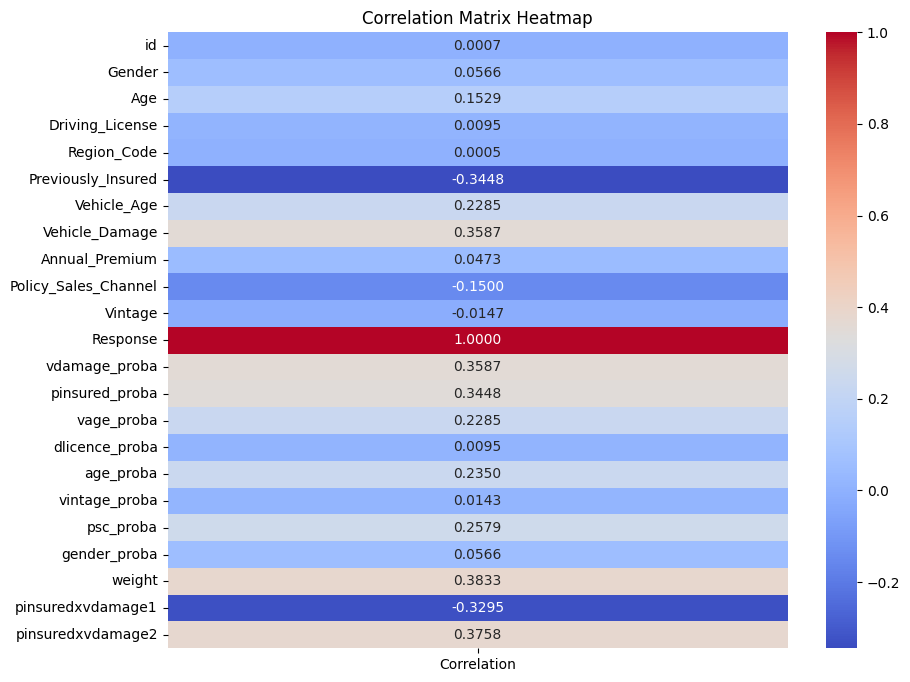

Elapsed time [m]:  0.1243


In [32]:
t1 = time.time()
# Pearson method for this one since air temperature has linear relationship with heating tendency
corr = pd.DataFrame(c.corrwith(c['Response'], method='spearman'), columns=['Correlation'])

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.4f')
plt.title('Correlation Matrix Heatmap')
plt.show()
t2 = time.time()
print('Elapsed time [m]: ', np.round((t2-t1)/60,4))

In [ ]:
plot_feature_importanc(train.drop('vdamage_proba', 'pinsured_proba', 'vage_proba', 'dlicence_proba'))

In [123]:
features = train.drop('id', 'Response').columns
features

['Gender',
 'Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'vdamage_proba',
 'pinsured_proba',
 'vage_proba',
 'age_proba',
 'dlicence_proba',
 'weight',
 'vintage_proba']

In [36]:
t1 = time.time()
X_copy = train[:1000000]
y_copy = train[:1000000]['Response']

mi_scores = mutual_info_classif(X_copy, y_copy, discrete_features=X_copy.dtypes==int, n_neighbors=5, random_state=42)
mi_scores = pd.Series(mi_scores, index=train.columns)
mi_scores = mi_scores.sort_values(ascending=False)
t2 = time.time()
print('Elapsed time [m]: ', np.round((t2-t1)/60,4))
mi_scores

NameError: name 't2' is not defined

In [37]:
mi_scores

Response                0.377001
Previously_Insured      0.160072
pinsuredxvdamage1       0.146964
pinsured_proba          0.143362
Vehicle_Damage          0.138354
pinsuredxvdamage2       0.138005
vdamage_proba           0.137195
dlicence_proba          0.108772
weight                  0.106309
Driving_License         0.096781
vage_proba              0.077901
Gender                  0.076396
Policy_Sales_Channel    0.066813
psc_proba               0.059542
Vehicle_Age             0.058704
gender_proba            0.039373
Age                     0.035161
age_proba               0.034497
Annual_Premium          0.031244
Region_Code             0.022705
Vintage                 0.014226
vintage_proba           0.013776
id                      0.000014
dtype: float64

## Normalizing The Data:

In [63]:
scaler = RobustScaler()

# Fit the scaler to the data
scaler.fit(train[:1000000][num_cols])

# Transform the data
train[:1000000][num_cols] = scaler.transform(train[:1000000][num_cols])

In [64]:
gc.collect()

4

# Train

In [65]:
features = train.drop('id', 'Response').columns
mandatory = ['age_proba', 'Vehicle_Damage', 'psc_proba', 'Previously_Insured', 'dlicence_proba',
             'Annual_Premium', 'Policy_Sales_Channel', 'Age', 'vintage_proba', 'pinsuredxvdamage1']
remaining = [f for f in features if f not in mandatory]
all_combinations = feature_combinations_with_mandatory(mandatory, remaining, (10-len(mandatory)))

In [66]:
len(all_combinations)

1

In [67]:
a = train[:1000000].to_pandas()
weight = weights[:1000000]

#X = a.drop(columns=['id', 'Response'], axis=1).values
#y = a['Response'].values

In [51]:
for combo in all_combinations:
    try:
        X = a[combo].values  #.drop(columns=['id', 'Response'], axis=1).values
        y = a['Response'].values
        
        cross_validate(X, y, weight, 5)
        print(f"Combo: {combo}")
    except LinAlgError as e:
        print(f"LinAlgError for combo {combo}: {e}")
    except Exception as e:
        print(f"Error for combo {combo}: {e}")
    gc.collect()

         Current function value: 0.266489
         Iterations: 35
         Current function value: 0.266259
         Iterations: 35
         Current function value: 0.266860
         Iterations: 35
         Current function value: 0.266701
         Iterations: 35
         Current function value: 0.266649
         Iterations: 35
Cross-validation scores: [0.8505534421200706, 0.8501540154508854, 0.853135328696196, 0.8516322005714645, 0.8513094105190662]
Mean cross-validation score: 0.8513568794715367
Standard deviation of cross-validation scores: 0.0010327952443842585
Combo: ['age_proba', 'Vehicle_Damage', 'psc_proba', 'Previously_Insured', 'Annual_Premium', 'Policy_Sales_Channel', 'Age', 'vintage_proba', 'pinsuredxvdamage1', 'pinsuredxvdamage2']


In [68]:
X = a[mandatory].values  #.drop(columns=['id', 'Response'], axis=1).values
y = a['Response'].values

In [69]:
model = train_logit_model(X, y)

Optimization terminated successfully.
         Current function value: 0.266535
         Iterations 12


In [70]:
#X = train[mandatory].to_pandas().values  #.drop(columns=['id', 'Response'], axis=1).values
#y = train['Response'].to_pandas().values

In [71]:
X_test = sm.add_constant(X)
y_pred = model.predict(X_test)
print(roc_auc_score(y, y_pred))

0.8526545700194788


In [72]:
max(y_pred)

0.9364902255174543

In [73]:
gc.collect()

0

# Some More EDA

In [74]:
residuals = y - y_pred
ids = []
for i, val in enumerate(residuals):
    if np.abs(val) >= 0.95:
        ids.append(i)
        #print(i, val)

In [75]:
bad_preds = train.filter(pl.col('id').is_in(ids))
bad_preds

id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,vdamage_proba,pinsured_proba,vage_proba,dlicence_proba,age_proba,vintage_proba,psc_proba,gender_proba,weight,pinsuredxvdamage1,pinsuredxvdamage2
i32,i8,i8,i8,f32,i8,i8,i8,f32,f32,i16,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8
825,1,53,1,23.0,0,1,0,25765.0,154.0,277,1,0.0041,0.2284,0.1777,0.1231,0.173556,0.092999,0.249854,0.1396,43.304198,0,0
1828,1,36,1,28.0,1,1,1,2630.0,154.0,105,1,0.2405,0.0006,0.1777,0.1231,0.229487,0.087287,0.249854,0.1396,35.214935,0,0
3130,1,42,1,28.0,1,1,0,47326.0,124.0,54,1,0.0041,0.0006,0.1777,0.1231,0.209626,0.224616,0.192496,0.1396,22.799475,1,0
4167,0,25,1,11.0,0,0,0,34585.0,152.0,257,1,0.0041,0.2284,0.0414,0.1231,0.031249,0.095003,0.026222,0.1032,21.220124,0,0
4617,0,48,1,3.0,0,0,0,2630.0,1.0,174,1,0.0041,0.2284,0.0414,0.1231,0.217931,0.218774,0.024666,0.1032,29.795122,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
994264,1,24,1,35.0,0,0,0,2630.0,156.0,110,1,0.0041,0.2284,0.0414,0.1231,0.031142,0.132468,0.204927,0.1396,29.691034,0,0
995084,0,23,1,49.0,0,0,0,2630.0,152.0,298,1,0.0041,0.2284,0.0414,0.1231,0.033138,0.174054,0.026222,0.1032,23.056973,0,0
996570,1,63,1,30.0,1,1,0,2630.0,1.0,42,1,0.0041,0.0006,0.1777,0.1231,0.114553,0.139069,0.024666,0.1396,15.401169,1,0


Text(0.5, 1.0, 'Checking Imbalance in Training Data Or Response')

<Figure size 600x600 with 0 Axes>

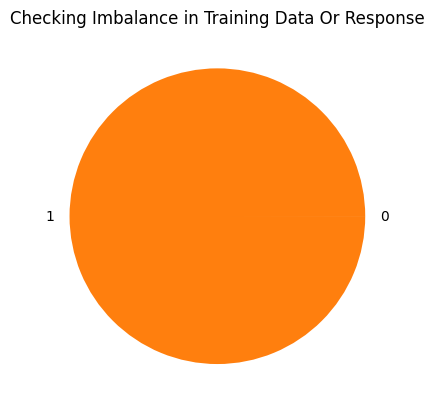

In [86]:
response_data = bad_preds['Response'].value_counts()['count']
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()
ax.pie(response_data, labels = [0,1])
ax.set_title('Checking Imbalance in Training Data Or Response')

In [87]:
bad_preds['Response'].value_counts()

Response,count
i64,u32
1,21947
0,1


Text(0.5, 1.0, 'Checking Imbalance in Training Data Or Response')

<Figure size 600x600 with 0 Axes>

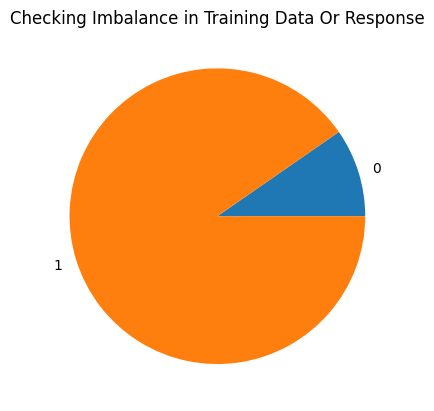

In [88]:
response_data = bad_preds['Vehicle_Damage'].value_counts()['count']
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()
ax.pie(response_data, labels = [0,1])
ax.set_title('Checking Imbalance in Training Data Or Response')

In [89]:
bad_preds['Vehicle_Damage'].value_counts()

Vehicle_Damage,count
i8,u32
1,19829
0,2119


Text(0.5, 1.0, 'Checking Imbalance in Training Data Or Response')

<Figure size 600x600 with 0 Axes>

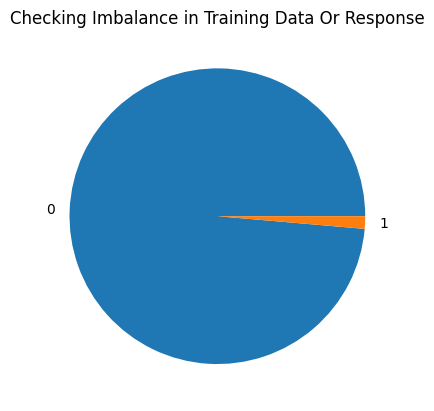

In [93]:
response_data = bad_preds['Previously_Insured'].value_counts()['count']
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()
ax.pie(response_data, labels = [0,1])
ax.set_title('Checking Imbalance in Training Data Or Response')

In [92]:
bad_preds['Previously_Insured'].value_counts()

Previously_Insured,count
i8,u32
0,21648
1,300


In [85]:
train.filter((pl.col('Previously_Insured') == 0) & (pl.col('Vehicle_Damage') == 1))

id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,vdamage_proba,pinsured_proba,vage_proba,dlicence_proba,age_proba,vintage_proba,psc_proba,gender_proba,weight,pinsuredxvdamage1,pinsuredxvdamage2
i32,i8,i8,i8,f32,i8,i8,i8,f32,f32,i16,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8
0,1,21,1,35.0,0,1,1,65101.0,124.0,187,0,0.2405,0.2284,0.1777,0.1231,0.031871,0.102365,0.192496,0.1396,57.097478,0,1
1,1,43,1,28.0,0,2,1,58911.0,26.0,288,1,0.2405,0.2284,0.299,0.1231,0.220596,0.099191,0.207763,0.1396,78.041165,0,1
3,0,35,1,1.0,0,1,1,2630.0,156.0,76,0,0.2405,0.2284,0.1777,0.1231,0.225718,0.09108,0.204927,0.1032,69.749962,0,1
7,0,47,1,8.0,0,1,1,40659.0,26.0,262,1,0.2405,0.2284,0.1777,0.1231,0.221149,0.151917,0.207763,0.1032,74.293824,0,1
9,0,66,1,11.0,0,1,1,2630.0,26.0,125,0,0.2405,0.2284,0.1777,0.1231,0.094869,0.108706,0.207763,0.1032,64.097157,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
11504784,1,25,1,28.0,0,0,1,48240.0,153.0,37,1,0.2405,0.2284,0.0414,0.1231,0.031249,0.052679,0.056011,0.1396,37.443568,0,1
11504787,0,22,1,13.0,0,0,1,31484.0,152.0,103,0,0.2405,0.2284,0.0414,0.1231,0.032953,0.126186,0.026222,0.1032,36.81986,0,1
11504793,1,48,1,6.0,0,1,1,27412.0,26.0,218,0,0.2405,0.2284,0.1777,0.1231,0.217931,0.248087,0.207763,0.1396,81.880863,0,1


In [66]:
residuals_series = pl.Series('residual', residuals)
b = train[:1000000].with_columns(residuals_series)

In [87]:
b.describe()

statistic,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,vdamage_proba,pinsured_proba,vage_proba,dlicence_proba,age_proba,vintage_proba,psc_proba,gender_proba,weight,pinsuredxvdamage1,pinsuredxvdamage2,residual
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6,1e6
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",499999.5,0.541233,38.400587,0.998032,26.433416,0.462342,0.603346,0.502973,30460.636719,112.319084,163.984809,0.122599,0.123003,0.123078,0.123017,0.122966,0.122974,0.125764,0.123108,0.122901,39.257772,0.438487,0.479118,8.2991e-18
"""std""",288675.278932,0.498297,15.009305,0.044318,12.989754,0.49858,0.567329,0.499991,16426.25,54.093704,79.934434,0.327977,0.118198,0.113577,0.075846,0.003014,0.08112,0.05386,0.089212,0.018138,26.314457,0.496202,0.499564,0.295622
"""min""",0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,2630.0,1.0,10.0,0.0,0.0041,0.0006,0.0414,0.0551,0.0,0.042442,0.0,0.1032,0.0,0.0,0.0,-0.838542
"""25%""",250000.0,0.0,24.0,1.0,15.0,0.0,0.0,0.0,25275.0,26.0,99.0,0.0,0.0041,0.0006,0.0414,0.1231,0.032953,0.087287,0.026222,0.1032,12.035194,0.0,0.0,-0.154586
"""50%""",500000.0,1.0,36.0,1.0,28.0,0.0,1.0,1.0,31824.0,150.0,166.0,0.0,0.2405,0.2284,0.1777,0.1231,0.126305,0.113501,0.171656,0.1396,34.565292,0.0,0.0,-0.000638
"""75%""",749999.0,1.0,49.0,1.0,35.0,1.0,1.0,1.0,39461.0,152.0,232.0,0.0,0.2405,0.2284,0.1777,0.1231,0.214765,0.153049,0.207763,0.1396,68.827447,1.0,1.0,-0.00018
"""max""",9.99999e5,1.0,85.0,1.0,52.0,1.0,2.0,1.0,540165.0,163.0,299.0,1.0,0.2405,0.2284,0.299,0.1231,0.233275,0.320056,0.833333,0.1396,94.390464,1.0,1.0,0.999861


In [67]:
b.filter(pl.col('id').is_in(ids)).describe()

statistic,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,vdamage_proba,pinsured_proba,vage_proba,dlicence_proba,age_proba,vintage_proba,psc_proba,gender_proba,weight,pinsuredxvdamage1,pinsuredxvdamage2,residual
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0,1427.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",489196.508059,0.550806,34.121934,0.992992,25.141556,0.210231,0.422565,0.121233,20957.302734,127.566223,161.89979,1.0,0.03276,0.180509,0.098954,0.122623,0.101358,0.125289,0.107601,0.123249,28.627057,0.098108,0.00911,0.978729
"""std""",282823.145702,0.497586,13.732895,0.083447,13.375927,0.407616,0.499785,0.326513,16514.486328,48.797779,79.071987,0.0,0.077188,0.092855,0.067992,0.005674,0.07712,0.05309,0.091221,0.018112,9.147297,0.297565,0.095044,0.014266
"""min""",825.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,2630.0,1.0,10.0,1.0,0.0041,0.0006,0.0414,0.0551,0.022438,0.042442,0.020696,0.1032,9.269441,0.0,0.0,0.950002
"""25%""",247226.0,0.0,24.0,1.0,13.0,0.0,0.0,0.0,2630.0,124.0,101.0,1.0,0.0041,0.2284,0.0414,0.1231,0.032568,0.087287,0.026222,0.1032,21.894971,0.0,0.0,0.966684
"""50%""",483787.0,1.0,28.0,1.0,28.0,0.0,0.0,0.0,26182.0,152.0,170.0,1.0,0.0041,0.2284,0.0414,0.1231,0.068727,0.115085,0.026222,0.1396,25.216455,0.0,0.0,0.984446
"""75%""",728490.0,1.0,44.0,1.0,35.0,0.0,1.0,0.0,33416.0,156.0,228.0,1.0,0.0041,0.2284,0.1777,0.1231,0.186159,0.152836,0.204927,0.1396,36.146348,0.0,0.0,0.986862
"""max""",999492.0,1.0,80.0,1.0,52.0,1.0,2.0,1.0,75912.0,163.0,299.0,1.0,0.2405,0.2284,0.299,0.1231,0.233275,0.320056,0.315977,0.1396,57.258587,1.0,1.0,0.99986


In [89]:
c = b.drop('Response').to_pandas()

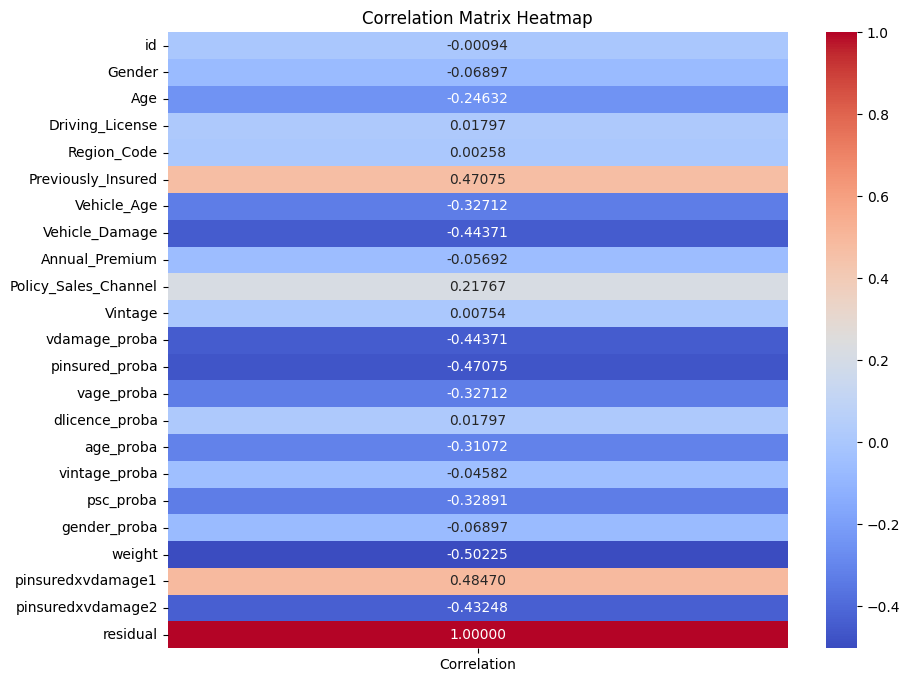

Elapsed time [m]:  0.2175


In [90]:
t1 = time.time()
# Pearson method for this one since air temperature has linear relationship with heating tendency
corr = pd.DataFrame(c.corrwith(c['residual'], method='spearman'), columns=['Correlation'])

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.5f')
plt.title('Correlation Matrix Heatmap')
plt.show()
t2 = time.time()
print('Elapsed time [m]: ', np.round((t2-t1)/60,4))

# Training Again

In [91]:
a = train[:1000000].filter(~pl.col('id').is_in(ids)).to_pandas()

In [92]:
X = a[mandatory] #.values
y = a['Response'] #.values

In [ ]:
cross_validate(X, y, weights, 5)

In [48]:
model = train_logit_model(X, y)

         Current function value: 0.260067
         Iterations: 35


In [49]:
X_test = sm.add_constant(X)
y_pred = model.predict(X_test)
print(roc_auc_score(y, y_pred))

0.8564591358047323


In [78]:
train[:1000000][num_cols] = scaler.inverse_transform(train[:1000000][num_cols])

In [82]:
a = train[:1000000].filter(~pl.col('id').is_in(ids)).to_pandas()

In [83]:
FOLDS = 5
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

In [65]:
X.columns.values.tolist()

['age_proba',
 'Vehicle_Damage',
 'psc_proba',
 'Previously_Insured',
 'dlicence_proba',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Age',
 'vintage_proba',
 'pinsuredxvdamage1',
 'pinsuredxvdamage2']

In [72]:
scores = []

best_score = 0
best_model = None

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print("#" * 25)
    print(f"# Fold {fold + 1}")
    print("#" * 25)
    X_train_fold = X.loc[train_idx]
    y_train_fold = y.loc[train_idx].values
    X_val_fold = X.loc[val_idx]
    y_val_fold = y.loc[val_idx].values
    X_train_pool = Pool(X_train_fold, y_train_fold)
    X_val_pool = Pool(X_val_fold, y_val_fold)
    
    # Train CatBoost
    model_1 = cb.CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        class_names=[0, 1],
        learning_rate=0.075,
        iterations=5000,
        depth=9,
        random_strength=0,
        l2_leaf_reg=0.5,
        max_leaves=512,
        fold_permutation_block=64,
        random_seed=42,
        verbose=False
    )

    model_1.fit(X=X_train_pool, 
              eval_set=X_val_pool, 
              verbose=500, 
              early_stopping_rounds=200)

    score = model_1.best_score_['validation']['AUC']
    print('Fold ROC-AUC score: ', score)
    scores.append(score)

    if score > best_score:
        best_score = score
        best_model = model_1

    del model_1
    del X_train_fold, y_train_fold
    del X_val_fold, y_val_fold
    del X_train_pool, X_val_pool
    gc.collect()

print('Mean ROC-AUC score: ', sum(scores) / FOLDS)
print('Best ROC-AUC score: ', best_score)
model_1 = best_model
del best_model

#########################
# Fold 1
#########################
0:	test: 0.8586668	best: 0.8586668 (0)	total: 656ms	remaining: 54m 38s
500:	test: 0.8761386	best: 0.8761386 (500)	total: 4m 18s	remaining: 38m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8764425404
bestIteration = 693

Shrink model to first 694 iterations.
Fold ROC-AUC score:  0.8764425403977779
#########################
# Fold 2
#########################
0:	test: 0.8576157	best: 0.8576157 (0)	total: 504ms	remaining: 41m 57s
500:	test: 0.8753025	best: 0.8753025 (500)	total: 4m 37s	remaining: 41m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8756855236
bestIteration = 732

Shrink model to first 733 iterations.
Fold ROC-AUC score:  0.8756855236383319
#########################
# Fold 3
#########################
0:	test: 0.8580526	best: 0.8580526 (0)	total: 482ms	remaining: 40m 8s
500:	test: 0.8758484	best: 0.8758621 (496)	total: 3m 29s	remaining: 31m 18s
Stopped by overfitt

In [73]:
model_1

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [95]:
model = train_xgboost_model(train, mandatory)

[0]	validation_0-auc:0.83947
[1]	validation_0-auc:0.83973
[2]	validation_0-auc:0.83951
[3]	validation_0-auc:0.85452
[4]	validation_0-auc:0.85563
[5]	validation_0-auc:0.85936
[6]	validation_0-auc:0.86040
[7]	validation_0-auc:0.86148
[8]	validation_0-auc:0.86123
[9]	validation_0-auc:0.86129
[10]	validation_0-auc:0.86421
[11]	validation_0-auc:0.86552
[12]	validation_0-auc:0.86494
[13]	validation_0-auc:0.86565
[14]	validation_0-auc:0.86556
[15]	validation_0-auc:0.86627
[16]	validation_0-auc:0.86547
[17]	validation_0-auc:0.86580
[18]	validation_0-auc:0.86580
[19]	validation_0-auc:0.86484
[20]	validation_0-auc:0.86462
[21]	validation_0-auc:0.86491
[22]	validation_0-auc:0.86547
[23]	validation_0-auc:0.86569
[24]	validation_0-auc:0.86592
[25]	validation_0-auc:0.86602
[26]	validation_0-auc:0.86592
[27]	validation_0-auc:0.86640
[28]	validation_0-auc:0.86676
[29]	validation_0-auc:0.86674
[30]	validation_0-auc:0.86689
[31]	validation_0-auc:0.86693
[32]	validation_0-auc:0.86710
[33]	validation_0-au

IOStream.flush timed out


[98]	validation_0-auc:0.86960
[99]	validation_0-auc:0.86968


In [96]:
y_pred = model.predict(X)
print(roc_auc_score(y, y_pred))

0.5095939300105629


In [71]:
gc.collect()

1391

In [ ]:
del a, X, y, train, weights, b, c, corr

# Predict

In [77]:
submit()